In [1]:
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
from PIL import Image, ImageChops
import requests
import torch
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

/var/home/daniel/micromamba/envs/mambaenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-23 00:47:38.525200: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

# Load Mask2Former trained on COCO panoptic segmentation dataset
image_processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-coco-panoptic")
model = Mask2FormerForUniversalSegmentation.from_pretrained(
    "facebook/mask2former-swin-large-coco-panoptic"
)


/var/home/daniel/micromamba/envs/mambaenv/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [3]:
def data_transform(data):
    data = data - np.min(data)
    data = np.round(data * 255/np.max(data))
    data = data.astype(np.uint8)
    return np.array(data)

def train_patches(directory):
    transformed_data_list = []
    targets = []
    non_targets = []
    density = []
    transformed_data_list_eval = []
    targets_eval = []
    non_targets_eval = []
    density_eval = []

    print('Retrieving training data:')
    for i in tqdm(range(10)):  # Range from 0 to 3565 for train samples
        filename = f"train_{i}.pt"
        file_path = os.path.join(directory, filename)
        if os.path.exists(file_path):
            try:
                data0 = torch.load(file_path)
                data1 = data0['aerial_20'].numpy()
                data1 = data1.transpose()
                transformed_data = data_transform(data1)
                transformed_data_list.append(transformed_data)
                
                target1 = data0['target'].numpy()
                targets.append(target1)
                
                nontargets1 = data0['target_mask'].numpy() - target1
                non_targets.append(nontargets1)

                density1 = data0['density'].numpy()
                density.append(density1)
            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")
    
    print('Retrieving validation data:')
    for i in tqdm(range(8)):  # Range from 0 to 787 for val samples
        filename = f"val_{i}.pt"
        file_path = os.path.join(directory, filename)
        if os.path.exists(file_path):
            try:
                data0 = torch.load(file_path)
                data1 = data0['aerial_20'].numpy()
                data1 = data1.transpose()
                transformed_data = data_transform(data1)
                transformed_data_list_eval.append(transformed_data)
                
                target1 = data0['target'].numpy()
                targets_eval.append(target1)
                
                nontargets1 = data0['target_mask'].numpy() - target1
                non_targets_eval.append(nontargets1)

                density1 = data0['density'].numpy()
                density_eval.append(density1)
            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")

    return (transformed_data_list, targets, non_targets, density, 
            transformed_data_list_eval, targets_eval, non_targets_eval, density_eval)

data, targets, non_targets, density, data_eval, targets_eval, non_targets_eval, density_eval = train_patches('patches')

print('Total train patches retrived:',len(data))
print('Total evaluation patches retrived:',len(data_eval))

Retrieving training data:


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


Retrieving validation data:


100%|██████████| 8/8 [00:00<00:00, 76.37it/s]

Total train patches retrived: 10
Total evaluation patches retrived: 8


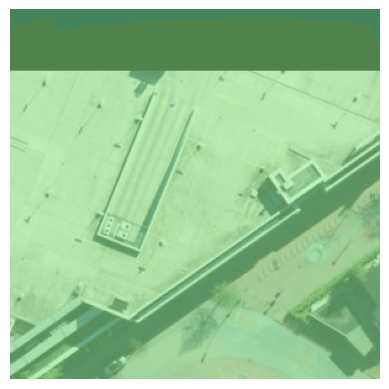

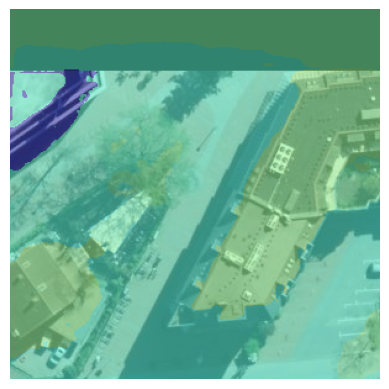

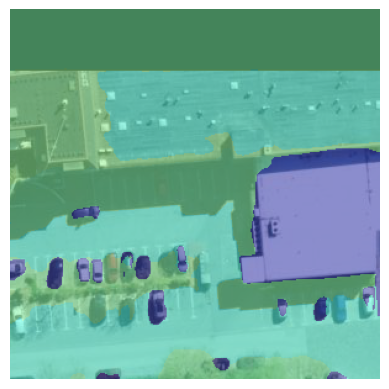

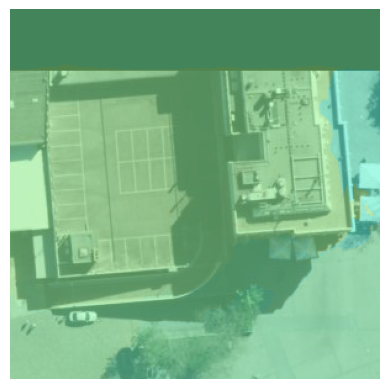

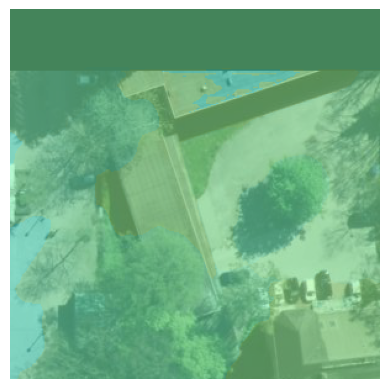

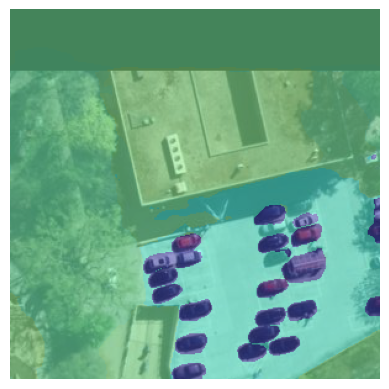

In [100]:
maps = []

for i, image_array in enumerate(data):
    # Convert ndarray to PIL Image
    image = Image.fromarray((image_array * 255).astype(np.uint8))
    inputs = image_processor(image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    class_queries_logits = outputs.class_queries_logits
    masks_queries_logits = outputs.masks_queries_logits

    pred_instance_map = image_processor.post_process_semantic_segmentation(
        outputs, target_sizes=[image.size[::-1]]
    )[0]

    maps.append(pred_instance_map)

    # Convert the grayscale segmented map to a colored one using a colormap
    pred_instance_map_colored = plt.get_cmap('jet')(pred_instance_map.byte().cpu().numpy())

    # Convert the colored map to a PIL Image
    pred_instance_map_image = Image.fromarray((pred_instance_map_colored * 255).astype(np.uint8))

    # Blend the original image with the colored segmented map using matplotlib
    fig, ax = plt.subplots()
    ax.imshow(data[i], alpha=0.8)
    ax.imshow(pred_instance_map_image, alpha=0.4)
    plt.axis('off')

IndexError: too many indices for tensor of dimension 2

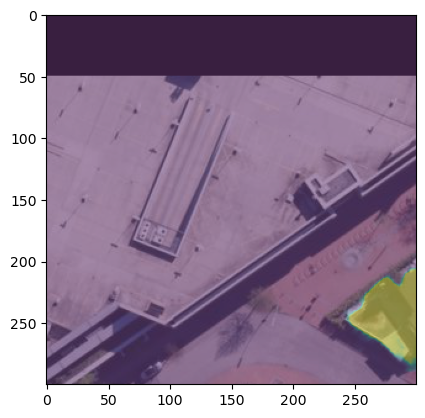

In [101]:
import torch.nn.functional as F

maps = []

data1 = data[0:1]

for i, image_array in enumerate(data):
    # Convert ndarray to PIL Image
    image = Image.fromarray((image_array * 255).astype(np.uint8))
    inputs = image_processor(image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    class_queries_logits = outputs.class_queries_logits
    masks_queries_logits = outputs.masks_queries_logits

    # Resize the logits to the original image size
    masks_queries_logits_resized = F.interpolate(masks_queries_logits, size=image.size[::-1], mode='bilinear', align_corners=False)

    # Apply sigmoid activation to masks_queries_logits
    masks_queries_logits_sigmoid = torch.sigmoid(masks_queries_logits_resized)

    pred_instance_map = image_processor.post_process_semantic_segmentation(
        outputs, target_sizes=[image.size[::-1]]
    )[0]

    maps.append(masks_queries_logits_sigmoid)

    # Convert the grayscale segmented map to a colored one using a colormap
    pred_instance_map_colored = plt.get_cmap('jet')(pred_instance_map.byte().cpu().numpy())

    # Convert the colored map to a PIL Image
    pred_instance_map_image = Image.fromarray((pred_instance_map_colored * 255).astype(np.uint8))

    # Blend the original image with the colored segmented map using matplotlib
    fig, ax = plt.subplots()
    ax.imshow(data[i], alpha=0.8)
    first_class_logits = masks_queries_logits_sigmoid[0, 0, :, :] # batch_size x num_queries x H x W - 200 queries and 1 in every batch
    masks_queries_logits_sigmoid = masks_queries_logits_sigmoid[0, 0, :, :] > 0.5

    ax.imshow(first_class_logits, alpha=0.4)  
    ax.imshow(masks_queries_logits_sigmoid[0, 1, :, :], alpha=0.4)  
    ax.imshow(masks_queries_logits_sigmoid[0, 2, :, :], alpha=0.4)  
 


    #ax.imshow(masks_queries_logits_sigmoid, alpha=0.4)
    plt.axis('off')



In [6]:
def combine_masks_average_overlap(masks):
        # Create an array to count the number of non-zero entries for each pixel
        count_non_zero = np.zeros_like(masks[0], dtype=np.float32)

        # Create an array to sum the probabilities for each pixel
        sum_probabilities = np.zeros_like(masks[0], dtype=np.float32)

        for mask in masks:
            mask = np.array(mask)
            # Update the count of non-zero entries
            count_non_zero += (mask > 0)

            # Add the probabilities to the sum (this includes zeros)
            sum_probabilities += mask

        # To avoid division by zero, we set the count to 1 for pixels where it's zero
        count_non_zero[count_non_zero == 0] = 1

        # Compute the average only for overlapping areas
        combined_mask = sum_probabilities / count_non_zero

        return combined_mask

(32, 300, 300)
(21, 300, 300)
(15, 300, 300)
(8, 300, 300)
(3, 300, 300)
(14, 300, 300)


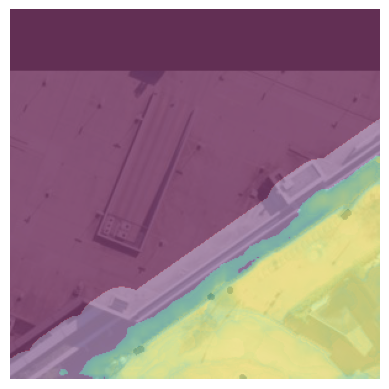

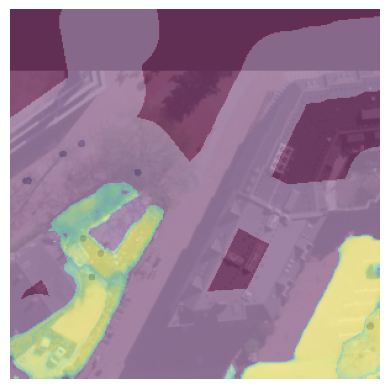

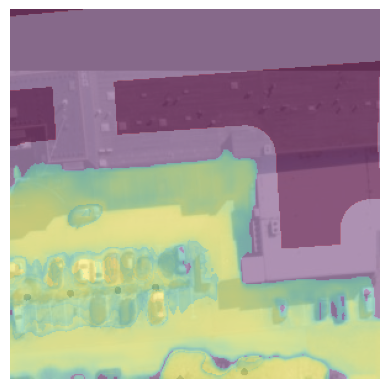

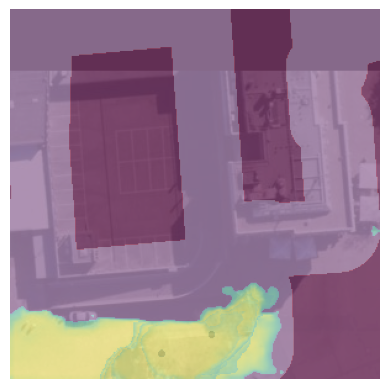

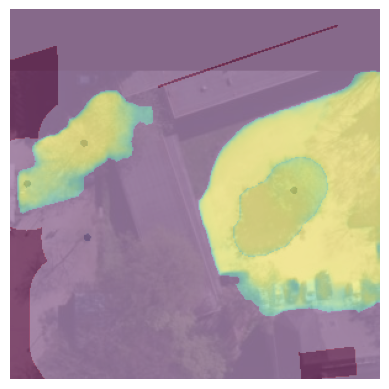

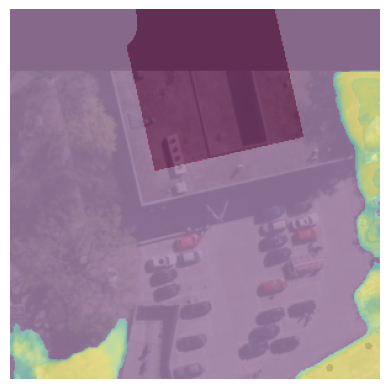

In [ ]:
data1 = data[0:10]

for i, image_array in enumerate(data1):
    maps = []
    image = Image.fromarray((image_array * 255).astype(np.uint8))
    inputs = image_processor(image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    class_queries_logits = outputs.class_queries_logits
    masks_queries_logits = outputs.masks_queries_logits
    

    masks_queries_logits_resized = F.interpolate(masks_queries_logits, size=image.size[::-1], mode='bilinear', align_corners=False)


    masks_queries_logits_sigmoid = torch.sigmoid(masks_queries_logits_resized)


    for mask_index in range(masks_queries_logits_sigmoid.shape[1]):
        mask = masks_queries_logits_sigmoid[0, mask_index, :, :]
        mask[mask < 0.5] = 0
        # Check if any part of the mask overlaps with the target
        if torch.sum(mask * targets[i].transpose()) > 0:
            # Check if none of the mask overlaps with the non-target
            if torch.sum(mask * non_targets[i].transpose()) == 0:
                maps.append(mask)

    pred_instance_map = image_processor.post_process_semantic_segmentation(
        outputs, target_sizes=[image.size[::-1]]
    )[0]

    # Convert the grayscale segmented map to a colored one using a colormap
    pred_instance_map_colored = plt.get_cmap('jet')(pred_instance_map.byte().cpu().numpy())

    # Convert the colored map to a PIL Image
    pred_instance_map_image = Image.fromarray((pred_instance_map_colored * 255).astype(np.uint8))

    print(np.shape(maps))

    combined_mask = combine_masks_average_overlap(maps)

    # Blend the original image with the colored segmented map using matplotlib
    fig, ax = plt.subplots()
    ax.imshow(data[i], alpha=0.8)
    ax.imshow(targets[i].transpose(), cmap='Blues', alpha=0.4)
    ax.imshow(non_targets[i].transpose(), cmap='Reds', alpha=0.4)
    ax.imshow(combined_mask, alpha=0.4)  

    plt.axis('off')


(20, 300, 300)
(14, 300, 300)
(14, 300, 300)
(6, 300, 300)
(2, 300, 300)
(9, 300, 300)
(17, 300, 300)
(8, 300, 300)
(0,)
(0,)


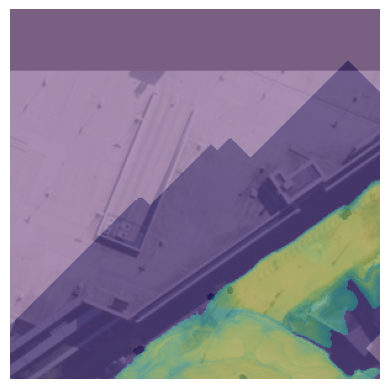

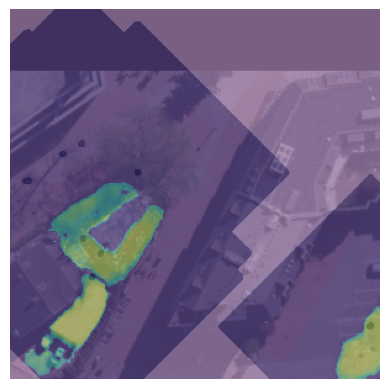

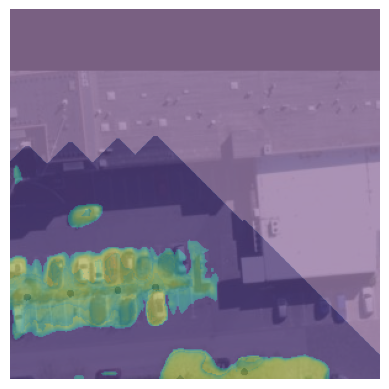

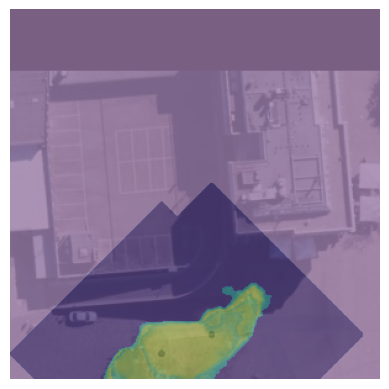

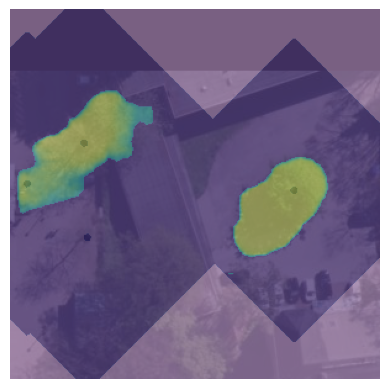

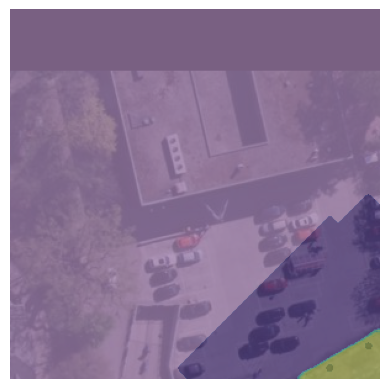

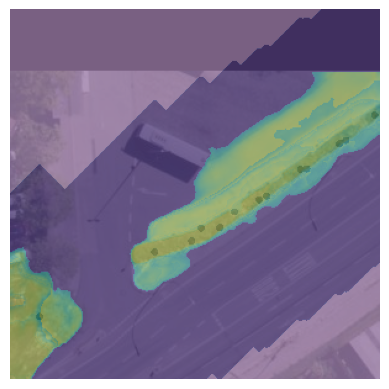

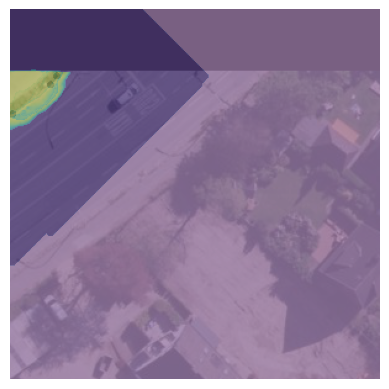

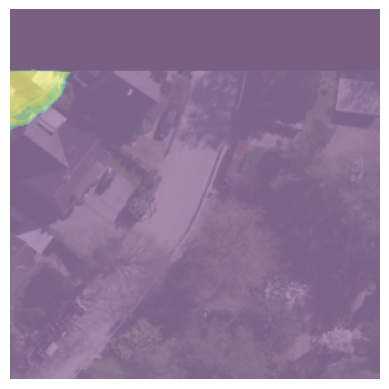

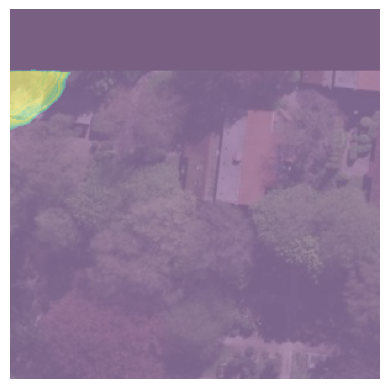

In [7]:
import scipy.ndimage as ndi
import torch.nn.functional as F

data1 = data[0:10]

for i, image_array in enumerate(data1):
    maps = []
    image = Image.fromarray((image_array * 255).astype(np.uint8))
    inputs = image_processor(image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    class_queries_logits = outputs.class_queries_logits
    masks_queries_logits = outputs.masks_queries_logits

    masks_queries_logits_resized = F.interpolate(masks_queries_logits, size=image.size[::-1], mode='bilinear', align_corners=False)
    masks_queries_logits_sigmoid = torch.sigmoid(masks_queries_logits_resized)

    for mask_index in range(masks_queries_logits_sigmoid.shape[1]):
        mask = masks_queries_logits_sigmoid[0, mask_index, :, :]
        mask[mask < 0.5] = 0

        # Create a binary mask for the target
        binary_target = np.where(targets[i].transpose() == 1, 1, 0)

        # Dilate the binary target by 30 pixels
        dilated_target = ndi.binary_dilation(binary_target, iterations=120)

        # Check if the entirety of the mask is within 30 pixels of the target
        if np.array_equal(mask * dilated_target, mask):
            # Check if any part of the mask overlaps with the target
            if torch.sum(mask * targets[i].transpose()) > 0:
                # Check if none of the mask overlaps with the non-target
                if torch.sum(mask * non_targets[i].transpose()) == 0:
                    maps.append(mask)

    pred_instance_map = image_processor.post_process_semantic_segmentation(
        outputs, target_sizes=[image.size[::-1]]
    )[0]

    # Convert the grayscale segmented map to a colored one using a colormap
    pred_instance_map_colored = plt.get_cmap('jet')(pred_instance_map.byte().cpu().numpy())

    # Convert the colored map to a PIL Image
    pred_instance_map_image = Image.fromarray((pred_instance_map_colored * 255).astype(np.uint8))

    print(np.shape(maps))
    if np.shape(maps)[0] != 0:
        combined_mask = combine_masks_average_overlap(maps)

    # Blend the original image with the colored segmented map using matplotlib
    fig, ax = plt.subplots()
    ax.imshow(data[i])
    ax.imshow(targets[i].transpose(), cmap='Blues', alpha=0.4)
    ax.imshow(dilated_target, cmap='Blues', alpha=0.4)
    #ax.imshow(non_targets[i].transpose(), cmap='Reds', alpha=0.4)
    ax.imshow(combined_mask, alpha=0.4)  

    plt.axis('off')


In [10]:
type(combined_mask.torch())


AttributeError: 'numpy.ndarray' object has no attribute 'torch'

(11, 300, 300)
(13, 300, 300)
(12, 300, 300)
(6, 300, 300)
(1, 300, 300)
(9, 300, 300)


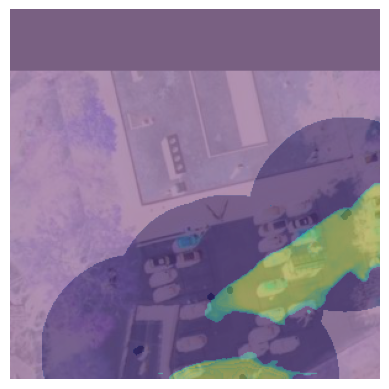

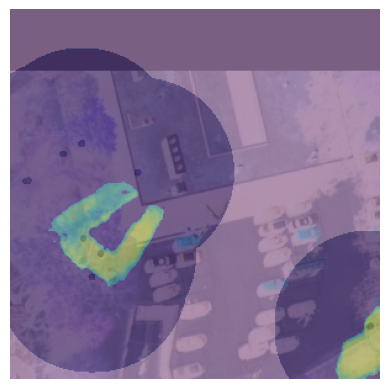

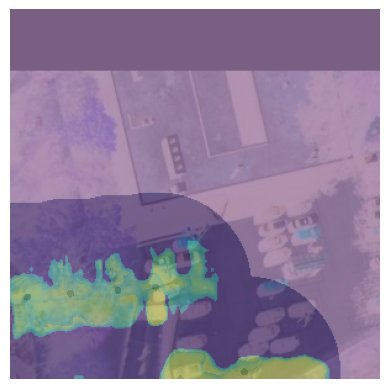

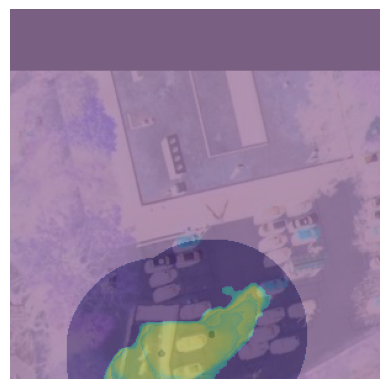

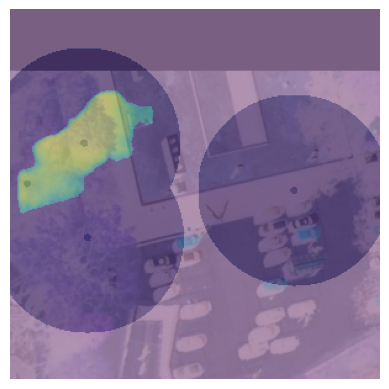

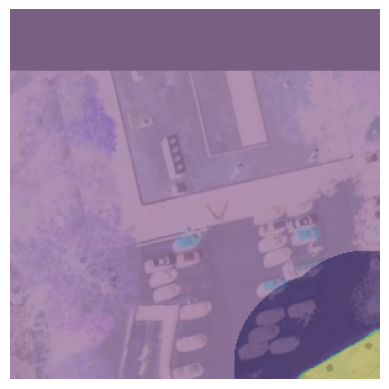

In [124]:
import numpy as np
from PIL import Image, ImageEnhance, ImageOps, ImageFilter
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage.morphology import dilation, disk

data1 = data[0:10]

for i, image_array in enumerate(data1):
    maps = []

    image = Image.fromarray((image_array * 255).astype(np.uint8))
    inputs = image_processor(image, return_tensors="pt")

    #enhancer = ImageEnhance.Color(image)
    #image_saturated = enhancer.enhance(2.0)  # Increase saturation

    #enhancer = ImageEnhance.Contrast(image_saturated)
    #image_contrasted = enhancer.enhance(1.5)  # Increase contrast

    # Apply histogram equalization
    #image_equalized = ImageOps.equalize(image_contrasted)

    # Apply a filter (e.g., sharpening)
    #image_sharpened = image_equalized.filter(ImageFilter.SHARPEN)

    #inputs = image_processor(image_sharpened, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    class_queries_logits = outputs.class_queries_logits
    masks_queries_logits = outputs.masks_queries_logits

    masks_queries_logits_resized = F.interpolate(masks_queries_logits, size=image.size[::-1], mode='bilinear', align_corners=False)
    masks_queries_logits_sigmoid = torch.sigmoid(masks_queries_logits_resized)

    for mask_index in range(masks_queries_logits_sigmoid.shape[1]):
        mask = masks_queries_logits_sigmoid[0, mask_index, :, :]
        mask[mask < 0.5] = 0

        # Create a binary mask for the target
        binary_target = np.where(targets[i].transpose() == 1, 1, 0).astype(np.uint8)

        # Use a smaller structuring element for faster operation
        selem = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (150, 150))

        # Perform dilation
        dilated_target = cv2.dilate(binary_target, selem)

        # Check if the entirety of the mask is within the dilated target
        if np.array_equal(mask * dilated_target, mask):
            # Check if any part of the mask overlaps with the target
            if torch.sum(mask * targets[i].transpose()) > 0:
                # Check if none of the mask overlaps with the non-target
                if torch.sum(mask * non_targets[i].transpose()) == 0:
                    maps.append(mask)
                    #continue
            #if torch.sum(mask * density[i].transpose()) > 0:
                #if torch.sum(mask * non_targets[i].transpose()) == 0:
                    #maps.append(mask)
        
    #if np.shape(maps)[0] != 0:
    #    combined_mask = combine_masks_average_overlap(maps)

    #coverage = np.logical_or((combined_mask > 0), (target == 0))

    #if not np.all(coverage):
            
                

    pred_instance_map = image_processor.post_process_semantic_segmentation(
        outputs, target_sizes=[image.size[::-1]]
    )[0]

    # Convert the grayscale segmented map to a colored one using a colormap
    pred_instance_map_colored = plt.get_cmap('jet')(pred_instance_map.byte().cpu().numpy())

    # Convert the colored map to a PIL Image
    pred_instance_map_image = Image.fromarray((pred_instance_map_colored * 255).astype(np.uint8))

    print(np.shape(maps))
    if np.shape(maps)[0] != 0:
        combined_mask = combine_masks_average_overlap(maps)

    

    # Blend the original image with the colored segmented map using matplotlib
    fig, ax = plt.subplots()
    ax.imshow(image_saturated)#data[i])
    ax.imshow(targets[i].transpose(), cmap='Blues', alpha=0.4)
    ax.imshow(dilated_target, cmap='Blues', alpha=0.4)
    ax.imshow(combined_mask, alpha=0.4)  

    plt.axis('off')



(11, 300, 300)
(13, 300, 300)
(12, 300, 300)
(6, 300, 300)
(1, 300, 300)
(9, 300, 300)
(17, 300, 300)
(8, 300, 300)
(0,)
(0,)


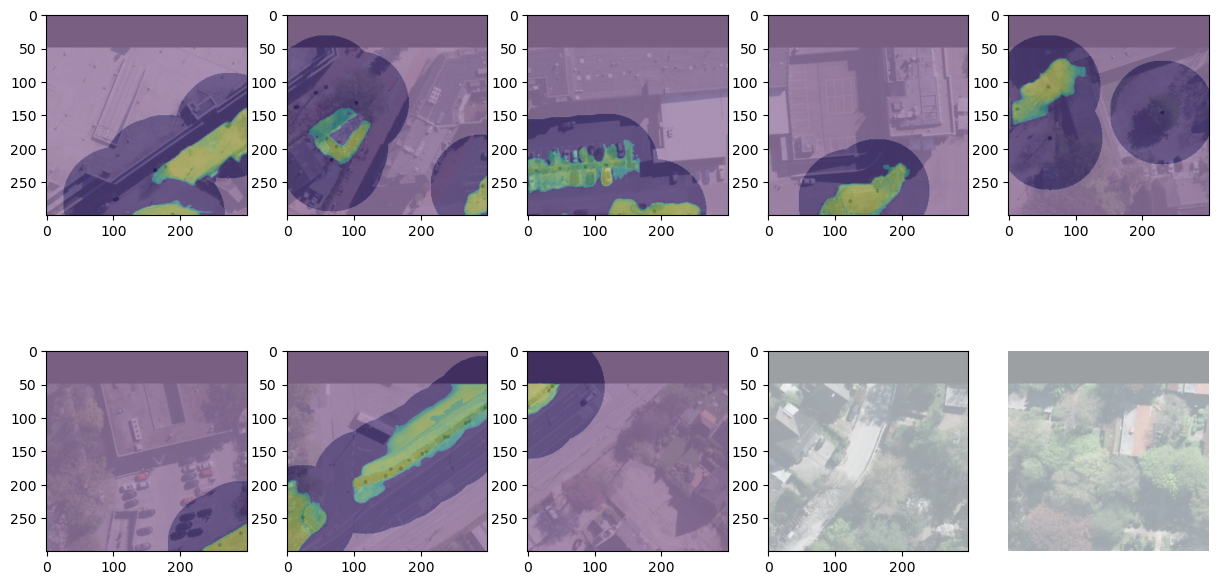

In [134]:
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage.morphology import dilation, disk

data1 = data[0:10]

fig, ax = plt.subplots(2, 5, figsize=(15, 8))

for i, image_array in enumerate(data1):
    maps = []
    comb_true = False

    image = Image.fromarray((image_array * 255).astype(np.uint8))
    inputs = image_processor(image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    class_queries_logits = outputs.class_queries_logits
    masks_queries_logits = outputs.masks_queries_logits

    masks_queries_logits_resized = F.interpolate(masks_queries_logits, size=image.size[::-1], mode='bilinear', align_corners=False)
    masks_queries_logits_sigmoid = torch.sigmoid(masks_queries_logits_resized)

    for mask_index in range(masks_queries_logits_sigmoid.shape[1]):
        mask = masks_queries_logits_sigmoid[0, mask_index, :, :]
        mask[mask < 0.5] = 0

        # Create a binary mask for the target
        binary_target = np.where(targets[i].transpose() == 1, 1, 0).astype(np.uint8)

        # Use a smaller structuring element for faster operation
        selem = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (150, 150))

        # Perform dilation
        dilated_target = cv2.dilate(binary_target, selem)

        # Check if the entirety of the mask is within the dilated target
        if np.array_equal(mask * dilated_target, mask):
            # Check if any part of the mask overlaps with the target
            if torch.sum(mask * targets[i].transpose()) > 0:
                # Check if none of the mask overlaps with the non-target
                if torch.sum(mask * non_targets[i].transpose()) == 0:
                    maps.append(mask)


    print(np.shape(maps))
    if np.shape(maps)[0] != 0:
        combined_mask = combine_masks_average_overlap(maps)
        comb_true = True

    ax[int(i > 4), i%5].imshow(data[i])
    ax[int(i > 4), i%5].imshow(targets[i].transpose(), cmap='Blues', alpha=0.4)
    ax[int(i > 4), i%5].imshow(dilated_target, cmap='Blues', alpha=0.4)
    if comb_true:
        ax[int(i > 4), i%5].imshow(combined_mask, alpha=0.4)  

    plt.axis('off')

In [ ]:
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage.morphology import dilation, disk

data1 = data[0:10]

fig, ax = plt.subplots(2, 5, figsize=(15, 15))

for i, image_array in enumerate(data1):
    maps = []

    image = Image.fromarray((image_array * 255).astype(np.uint8))
    inputs = image_processor(image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    class_queries_logits = outputs.class_queries_logits
    masks_queries_logits = outputs.masks_queries_logits

    masks_queries_logits_resized = F.interpolate(masks_queries_logits, size=image.size[::-1], mode='bilinear', align_corners=False)
    masks_queries_logits_sigmoid = torch.sigmoid(masks_queries_logits_resized)

    for mask_index in range(masks_queries_logits_sigmoid.shape[1]):
        mask = masks_queries_logits_sigmoid[0, mask_index, :, :]
        mask[mask < 0.5] = 0

        # Create a binary mask for the target
        binary_target = np.where(targets[i].transpose() == 1, 1, 0).astype(np.uint8)

        # Use a smaller structuring element for faster operation
        selem = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (150, 150))

        # Perform dilation
        dilated_target = cv2.dilate(binary_target, selem)

        # Check if the entirety of the mask is within the dilated target
        if np.array_equal(mask * dilated_target, mask):
            # Check if any part of the mask overlaps with the target
            if torch.sum(mask * targets[i].transpose()) > 0:
                # Check if none of the mask overlaps with the non-target
                if torch.sum(mask * non_targets[i].transpose()) == 0:
                    maps.append(mask)


    print(np.shape(maps))
    if np.shape(maps)[0] != 0:
        combined_mask = combine_masks_average_overlap(maps)

    ax[int(i > 4), i%5].imshow(data[i])
    ax[int(i > 4), i%5].imshow(targets[i].transpose(), cmap='Blues', alpha=0.4)
    ax[int(i > 4), i%5].imshow(dilated_target, cmap='Blues', alpha=0.4)
    ax[int(i > 4), i%5].imshow(combined_mask, alpha=0.4)  

    plt.axis('off')

In [133]:
# For instance segmentation
image_processor_instance = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-coco-instance")
model_instance = Mask2FormerForUniversalSegmentation.from_pretrained(
    "facebook/mask2former-swin-large-coco-instance"
)